# Cost Functions

A quick guide on how to use the built-in cost functions.

The Minuit2.jl package comes with few of common cost functions. Of course, you can write your own cost functions to use with Minuit2, but most of the cost function is always the same. What really varies is the statistical model which predicts the probability density as a function of the parameter values.

We demonstrate each cost function on a standard example from high-energy physics, the fit of a peak over some smooth background.

In [1]:
using Revise
using Minuit2
using Distributions
using FHist
using Plots

We generate our data by sampling from a Gaussian peak and from exponential background in the range 0 to 2. The original data is then binned. One can fit the original or the binned data.

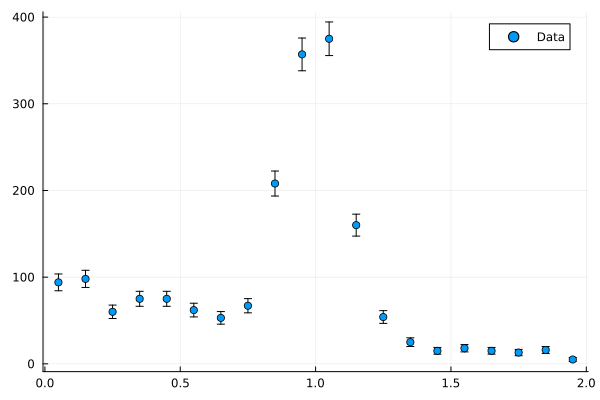

In [2]:
rng = (0, 2)
xdata = rand(Normal(1, 0.1), 1000)
ydata = rand(Exponential(1), length(xdata))
xmix = vcat(xdata, ydata)
xmix = xmix[(rng[1] .< xmix .< rng[2])]
h = Hist1D(xmix, nbins=20)
x = bincenters(h)
y = bincounts(h)
dy = sqrt.(y)
plot(x, y, yerr=dy, seriestype=:scatter, label="Data")

We also generate some 2D data to demonstrate multivariate fits. In this case, a Gaussian along axis 1 and independently an exponential along axis 2. In this case, the distributions are not restricted to some range in x and y.

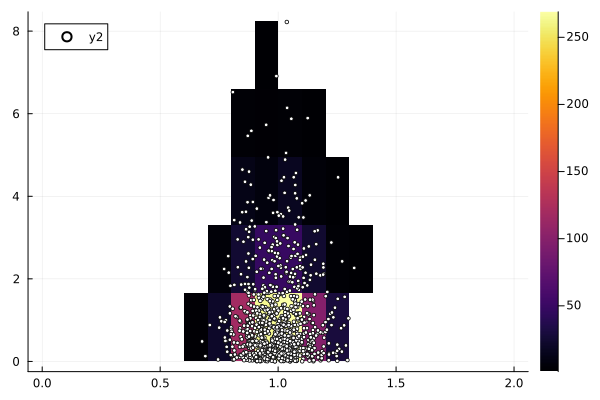

In [3]:
h2 = Hist2D((xdata, ydata), binedges=(range(rng..., 21), range(0., maximum(ydata), 6)))
plot(h2)
scatter!(xdata, ydata, markersize=2, color=:white)

## Maximum-likelihood fits

Maximum-likelihood fits are the state-of-the-art when it comes to fitting models to data. They can be applied to unbinned and binned data (histograms).

Unbinned fits are the easiest to use, because no data binning is needed. They become slow when the sample size is large.
Binned fits require you to appropriately bin the data. The binning has to be fine enough to retain all essential information. Binned fits are much faster when the sample size is large

### Unbinned fit

Unbinned fits are ideal when the data samples are not too large or very high dimensional. 
There is no need to worry about the appropriate binning of the data. Unbinned fits are inefficient 
when the samples are very large and can become numerically unstable, too. 
Binned fits are a better choice then.

The cost function an unbinned maximum-likelihood fit is really simple, it is the sum of the 
logarithm of the pdf evaluated at each sample point (times -1 to turn maximization into minimization).
You can easily write this yourself, but a naive implementation will suffer from instabilities 
when the pdf becomes locally zero. Our implementation mitigates the instabilities to some extent.
To perform the unbinned fit you need to provide the pdf of the model, which must be vectorized (a Numpy ufunc). 

The pdf must be normalized, which means that the integral over the sample value range must be a 
constant for any combination of model parameters. The model pdf in this case is a linear combination 
of the normal and the exponential pdfs. The parameters are  (the weight),  and  of the normal distribution and  of the exponential. The cost function detects the parameter names.

It is important to put appropriate limits on the parameters, so that the problem does not become mathematically undefined.

,
,
.
In addition, it can be beneficial to use , but it is not required. We use truncnorm and truncexpon, which are normalized inside the data range (0, 2).

In [4]:
my_pdf(x, ζ, μ, σ, τ) = ζ * pdf(truncated(Normal(μ, σ), rng...),x) + (1 - ζ) * pdf(truncated(Exponential(τ), rng...), x)

cost = UnbinnedNLL(xmix, my_pdf)
m = Minuit(cost, ζ=0.5, μ=1, σ=0.5, τ=1,
                 limit_ζ=(0, 1), limit_μ=(0, 2), limit_σ=(0, Inf), limit_τ=(0, Inf))

Minuit(FCN = UnbinnedNLL, X0 = Real[0.5, 1, 0.5, 1], Method = migrad)

In [5]:
migrad!(m)

┌──────────────┬──────────────┬───────────┬────────────┬────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ Up         │
│ 654.201      │              │ 125       │ 8          │ 0.5        │
├──────────────┼──────────────┼───────────┼────────────┼────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │ Call limit │ Edm        │
│ true         │ true         │ false     │ false      │ 2.04175e-8 │
├──────────────┼──────────────┼───────────┼────────────┼────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced     │
│ false        │ true         │ true      │ true       │ false      │
└──────────────┴──────────────┴───────────┴────────────┴────────────┘
┌───┬──────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────
│   │ Name │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixe ⋯
├───┼──────┼──────────┼─────────────┼────────┼────────┼────────┼────────┼───────
│ 1 │ ζ    │ 0.555335 │ 0.0107342   │        │        │ 0

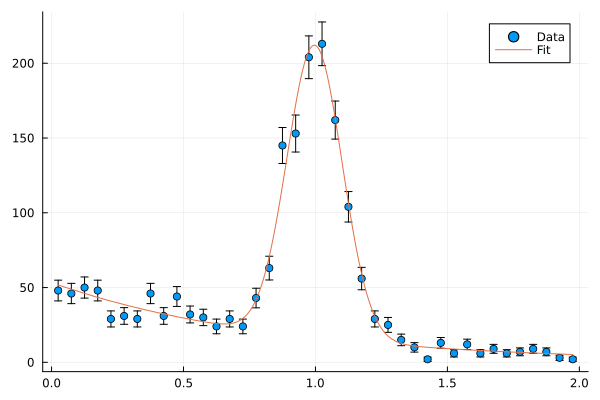

In [6]:
visualize(m)

In [7]:
minos!(m)

┌──────────────┬──────────────┬───────────┬────────────┬────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ Up         │
│ 654.201      │              │ 125       │ 8          │ 0.5        │
├──────────────┼──────────────┼───────────┼────────────┼────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │ Call limit │ Edm        │
│ true         │ true         │ false     │ false      │ 2.04175e-8 │
├──────────────┼──────────────┼───────────┼────────────┼────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced     │
│ false        │ true         │ true      │ true       │ false      │
└──────────────┴──────────────┴───────────┴────────────┴────────────┘
┌───┬──────┬──────────┬─────────────┬─────────────┬────────────┬────────┬───────
│   │ Name │ Value    │ Hesse Error │ Minos-      │ Minos+     │ Limit- │ Limi ⋯
├───┼──────┼──────────┼─────────────┼─────────────┼────────────┼────────┼───────
│ 1 │ ζ    │ 0.555335 │ 0.0107342   │ -0.0107096  │ 0.010

### Multivariate
We can also fit a multivariate model to multivariate data. We pass model as a `logpdf` this time, which works well because the pdfs factorize. The package `Distributions.jl` provides directly the function `logpdf`

In [8]:
function my_logpdf(xy, μ, σ, τ)
    x, y = xy
    logpdf(Normal(μ, σ), x) + logpdf(Exponential(τ), y)
end

c = UnbinnedNLL(hcat(xdata, ydata), my_logpdf, log=true)
m = Minuit(c, μ=1, σ=2, τ=2, limit_σ=(0,Inf), limit_τ=(0,Inf))
migrad!(m)

┌──────────────┬──────────────┬───────────┬────────────┬────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ Up         │
│ 372.142      │              │ 115       │ 9          │ 0.5        │
├──────────────┼──────────────┼───────────┼────────────┼────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │ Call limit │ Edm        │
│ true         │ true         │ false     │ false      │ 2.50434e-6 │
├──────────────┼──────────────┼───────────┼────────────┼────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced     │
│ false        │ true         │ true      │ true       │ false      │
└──────────────┴──────────────┴───────────┴────────────┴────────────┘
┌───┬──────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────
│   │ Name │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixe ⋯
├───┼──────┼──────────┼─────────────┼────────┼────────┼────────┼────────┼───────
│ 1 │ μ    │ 0.999504 │ 0.00232187  │        │        │  

### Binned Fit
Binned fits are computationally more efficient and numerically more stable when samples are large. The caveat is that one has to choose an appropriate binning. The binning should be fine enough so that the essential information in the original is retained. Using large bins does not introduce a bias, but the parameters have a larger-than-minimal variance.

In this case, 50 bins are fine enough to retain all information. Using many bins is safe, since the maximum-likelihood method correctly takes Poisson statistics into account, which works even if bins have zero entries. Using more bins than necessary just increases the computational cost.

Instead of a pdf, you need to provide a cdf for a binned fit (which must be vectorized)??

In [27]:
my_cdf(x, ζ, μ, σ, τ) = ζ * cdf(truncated(Normal(μ, σ), rng...),x) + (1 - ζ) * cdf(truncated(Exponential(τ), rng...), x)

h = Hist1D(xmix, nbins=20)
c = BinnedNLL(bincounts(h), binedges(h), my_cdf)
m = Minuit(c, ζ=0.4, μ=0, σ=0.2, τ=2, limit_ζ=(0, 1), limit_σ=(0, Inf), limit_τ=(0, Inf))
migrad!(m)

(args[1], args[2], args[3], args[4]) = (0.4, 0.0, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4086153933663498, 0.0, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.39141542555947384, 0.0, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4011761804338795, 0.0, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.3988243957014741, 0.0, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4, 0.008532115082147056, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4, -0.008532115082147056, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4, 0.08532115082147057, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4, -0.08532115082147057, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4, 0.0, 0.

DomainError: DomainError with NaN:
Normal: the condition σ >= zero(σ) is not satisfied.

In [10]:
visualize(m)

ArgumentError: ArgumentError: Minimization results not available

Sometimes the `cdf` is expensive to calculate. In this case, you can approximate taking the `pdf` evaluated at the center of the bin. This can be done with `use_pdf=:approximate` when defining the BinnedNNL cost.

In [29]:
#ROOT!Minuit2!MnPrint!SetGlobalLevel(2)
my_pdf(x, ζ, μ, σ, τ) = ζ * pdf(truncated(Normal(μ, σ), rng...),x) + (1 - ζ) * pdf(truncated(Exponential(τ), rng...), x)

c = BinnedNLL(bincounts(h), binedges(h), my_pdf, use_pdf=:approximate)
m = Minuit(c, ζ=0.4, μ=0, σ=0.2, τ=2, limit_ζ=(0, 1), limit_σ=(0, Inf), limit_τ=(0, Inf))
migrad!(m)

(args[1], args[2], args[3], args[4]) = (0.4, 0.0, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4073177962046639, 0.0, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.3927044498130454, 0.0, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4009980048322078, 0.0, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.39900241000142334, 0.0, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4, 0.007248907263158475, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4, -0.007248907263158475, 0.19999999999999996, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4, 0.0, 0.2075134902267255, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4, 0.0, 0.19259194340915498, 2.0000000000000004)
(args[1], args[2], args[3], args[4]) = (0.4, 0.0, 0.20204187673045615, 2.0000000000000

[Info] MnSeedGenerator Computing seed using NumericalGradient calculator
[Info] Numerical2PGradientCalculator Initial state: FCN =        22038.6653 Edm =       2126.142133 NCalls =     13
[Info] Numerical2PGradientCalculator Initial state  
  Minimum value : 22038.6653
  Edm           : 2126.142133
  Internal parameters:	[    -0.2013579208                0     0.6633249581      2.828427125]	
  Internal gradient  :	[      2019.866405     -501.3526599     -696.7035054     -73.85154771]	
  Internal covariance matrix:
[[  0.00078947376              0              0              0]
 [              0      0.0157144              0              0]
 [              0              0    0.002560069              0]
 [              0              0              0    0.016702099]]]
[Info] VariableMetricBuilder Start iterating until Edm is < 0.0002 with call limit = 680
[Info] VariableMetricBuilder    0 - FCN =        22038.6653 Edm =       2126.142133 NCalls =     13
[Info] VariableMetricBuilder    

(5.336305064496116e-9, 6.805303699389512, 1.5147674030343188, 2.0166731866161816)
(args[1], args[2], args[3], args[4]) = (5.336305064496116e-9, 6.805303699389512, 1.3326162414238567, 2.0166731866161816)
(args[1], args[2], args[3], args[4]) = (5.336305064496116e-9, 6.805303699389512, 1.441571720576753, 2.0166731866161816)
(args[1], args[2], args[3], args[4]) = (5.336305064496116e-9, 6.805303699389512, 1.4051364107672155, 2.0166731866161816)
(args[1], args[2], args[3], args[4]) = (5.336305064496116e-9, 6.805303699389512, 1.423340011339549, 2.0189144644042276)
(args[1], args[2], args[3], args[4]) = (5.336305064496116e-9, 6.805303699389512, 1.423340011339549, 2.014432114380048)
(args[1], args[2], args[3], args[4]) = (2.754679769456647e-6, 37.59417537512845, 1.423340011339549, 2.0166731866161816)
(args[1], args[2], args[3], args[4]) = (2.754679769456647e-6, 6.805303699389512, 1.886168431430015, 2.0166731866161816)
(args[1], args[2], args[3], args[4]) = (2.754679769456647e-6, 6.8053036993895

[Warn] MnPosDef Matrix forced pos-def by adding to diagonal 51.3755
[Info] MnPosDef After Hessian
[Info] VariableMetricBuilder    7 - FCN =       20961.41504 Edm =    0.001335176686 NCalls =    123
[Info] VariableMetricBuilder Tolerance not sufficient, continue minimization; Edm 0.00133518 Required 0.0002
[Info] VariableMetricBuilder    8 - FCN =       20961.41503 Edm =   2.660958692e-06 NCalls =    135
[Warn] MnPosDef Matrix forced pos-def by adding to diagonal 12.4589
[Info] MnPosDef After Hessian
[Info] VariableMetricBuilder    9 - FCN =       20961.41503 Edm =   3.351582617e-05 NCalls =    158


┌──────────────┬──────────────┬───────────┬────────────┬────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ Up         │
│ 20961.4      │              │ 158       │ 10         │ 1.0        │
├──────────────┼──────────────┼───────────┼────────────┼────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │ Call limit │ Edm        │
│ true         │ true         │ false     │ false      │ 3.35158e-5 │
├──────────────┼──────────────┼───────────┼────────────┼────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced     │
│ false        │ true         │ false     │ false      │ true       │
└──────────────┴──────────────┴───────────┴────────────┴────────────┘
┌───┬──────┬────────────┬─────────────┬────────┬────────┬────────┬────────┬─────
│   │ Name │ Value      │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fi ⋯
├───┼──────┼────────────┼─────────────┼────────┼────────┼────────┼────────┼─────
│ 1 │ ζ    │ 1.28351e-7 │ 0.683032    │        │        │

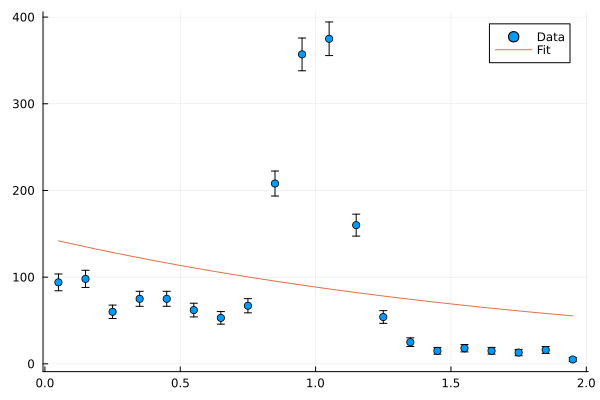

In [12]:
visualize(m)

#### Multi-dimensional Binned fit
Fitting a multidimensional histogram is easy. Since the `pdfs` in this example factorise, the cdf of the 2D model is the product of the cdfs along each axis.

In [13]:
my_cdf2(xy, μ, σ, τ) = cdf(Normal(μ, σ),xy[1]) * cdf(Exponential(τ), xy[2])

h2 = Hist2D((xdata, ydata), nbins=(20, 20))
c = BinnedNLL(bincounts(h2), binedges(h2), my_cdf2)
m = Minuit(c, ζ=0.4, μ=1, σ=2, τ=2, limit_σ=(0, Inf), limit_τ=(0, Inf))
migrad!(m)

(args[1], args[2], args[3], args[4]) = (1.0, 2.0000000000000004, 2.0000000000000004, 0.0)
(args[1], args[2], args[3], args[4]) = (1.005176496742839, 2.0000000000000004, 2.0000000000000004, 0.0)
(args[1], args[2], args[3], args[4]) = (0.9948235032571612, 2.0000000000000004, 2.0000000000000004, 0.0)
(args[1], args[2], args[3], args[4]) = (1.0, 2.0051774591506932, 2.0000000000000004, 0.0)
(args[1], args[2], args[3], args[4]) = (1.0, 1.9948236575321938, 2.0000000000000004, 0.0)
(args[1], args[2], args[3], args[4]) = (1.0, 2.010073099770209, 2.0000000000000004, 0.0)
(args[1], args[2], args[3], args[4]) = (1.0, 1.9899311263141182, 2.0000000000000004, 0.0)
(args[1], args[2], args[3], args[4]) = (1.0, 2.0000000000000004, 2.0051774591506932, 0.0)
(args[1], args[2], args[3], args[4]) = (1.0, 2.0000000000000004, 1.9948236575321938, 0.0)
(args[1], args[2], args[3], args[4]) = (1.0, 2.0000000000000004, 2.0121502678364163, 0.0)
(args[1], args[2], args[3], args[4]) = (1.0, 2.0000000000000004, 1.98785

┌──────────────┬──────────────┬───────────┬────────────┬────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ Up         │
│ 9009.0       │              │ 118       │ 6          │ 1.0        │
├──────────────┼──────────────┼───────────┼────────────┼────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │ Call limit │ Edm        │
│ true         │ true         │ false     │ false      │ 1.22326e-5 │
├──────────────┼──────────────┼───────────┼────────────┼────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced     │
│ false        │ true         │ true      │ true       │ false      │
└──────────────┴──────────────┴───────────┴────────────┴────────────┘
┌───┬──────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────
│   │ Name │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixe ⋯
├───┼──────┼──────────┼─────────────┼────────┼────────┼────────┼────────┼───────
│ 1 │ μ    │ 0.906704 │ 0.00621485  │        │        │  

## Least-squares fits

A cost function for a general weighted least-squares fit (aka chi-square fit) is also included. In statistics this is called non-linear regression.

In this case you need to provide a model that predicts the y-values as a function of the x-values and the parameters. The fit needs estimates of the y-errors. If those are wrong, the fit may be biased. If your data has errors on the x-values as well, checkout the tutorial about automatic differentiation, which includes an application of that to such fits.

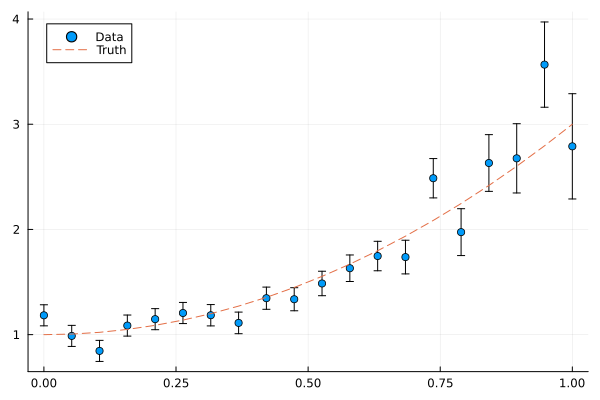

In [14]:
# Define the model
model(x, a, b) = a + b * x^2

# Define the data and truth
truth = 1, 2
x = range(0, 1., 20)
yt = model.(x, truth...)
ye = 0.4 .* x.^5 .+ 0.1
y = yt + ye .* randn(length(x))

# Plot with error bars
plot(x, y, yerr=ye, seriestype=:scatter, label="Data")
plot!(x, yt, label="Truth", linestyle=:dash)

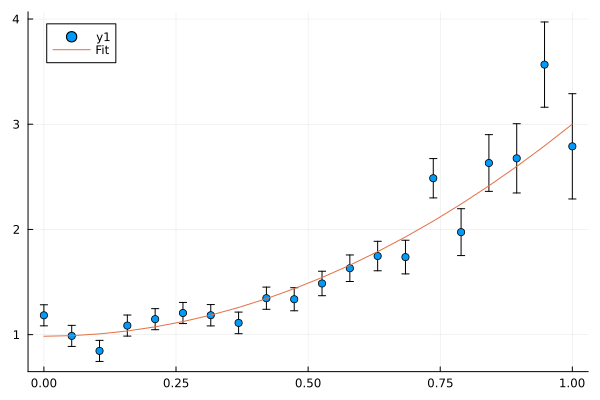

In [15]:
c = LeastSquares(x, y, ye, model)
m1 = Minuit(c, a=0, b=0)
migrad!(m1)
visualize(m1)

In [16]:
m1.parameters

┌───┬──────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────
│   │ Name │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixe ⋯
├───┼──────┼──────────┼─────────────┼────────┼────────┼────────┼────────┼───────
│ 1 │ a    │ 0.984952 │ 0.0372301   │        │        │        │        │      ⋯
│ 2 │ b    │ 2.01624  │ 0.150494    │        │        │        │        │      ⋯
└───┴──────┴──────────┴─────────────┴────────┴────────┴────────┴────────┴───────
                                                               2 columns omitted


### Multivariate model

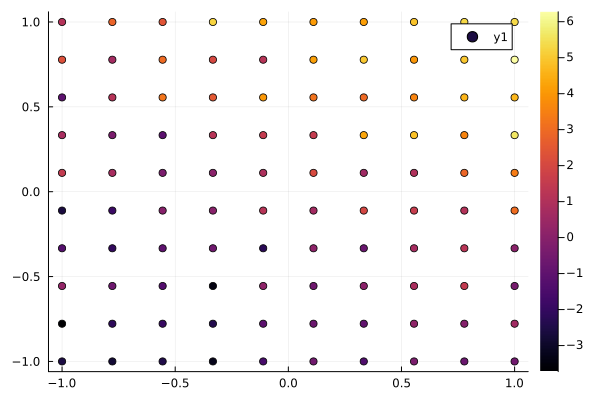

In [17]:
function model2(xy, a, bx, by)
    x, y = xy
    return a + bx * x + by * y
end

function model2_grad(xy, a, bx, by)
    x, y = xy
    return [1, x, y]
end

# generate a regular grid in x and y
xy = [(x,y) for x in range(-1.,1.,10) for y in range(-1.,1.,10)]

# model truth 
zt = model2.(xy, 1, 2, 3)

zerror = 1.
z = zt .+ zerror .* randn(length(xy))

scatter(xy, zcolor=z)

In [18]:
c2 = LeastSquares(xy, z, zerror, model2)
m2 = Minuit(c2, 0, 0, 0)
migrad!(m2)

┌──────────────┬──────────────┬───────────┬────────────┬─────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ Up          │
│ 91.867       │              │ 34        │ 3          │ 1.0         │
├──────────────┼──────────────┼───────────┼────────────┼─────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │ Call limit │ Edm         │
│ true         │ true         │ false     │ false      │ 5.09029e-16 │
├──────────────┼──────────────┼───────────┼────────────┼─────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced      │
│ false        │ true         │ true      │ true       │ false       │
└──────────────┴──────────────┴───────────┴────────────┴─────────────┘
┌───┬──────┬─────────┬─────────────┬────────┬────────┬────────┬────────┬────────
│   │ Name │ Value   │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixed ⋯
├───┼──────┼─────────┼─────────────┼────────┼────────┼────────┼────────┼────────
│ 1 │ a    │ 1.02961 │ 0.1         │        │  

Multivariate fits are difficult to check by eye. Here we use color to indicate the function value.

To guarantee that plot of the function and the plot of the data use the same color scale.

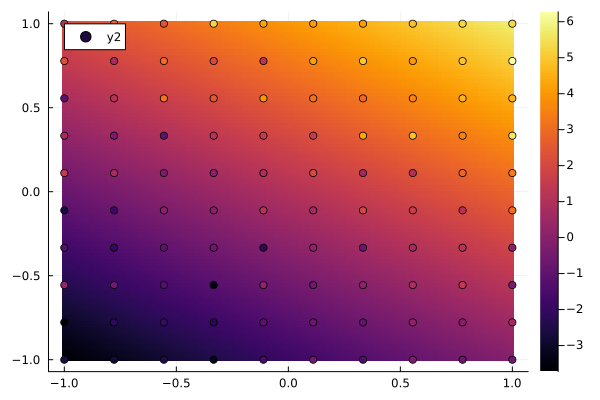

In [19]:
heatmap(range(-1.,1.,100), range(-1.,1.,100), (x,y)->model2((x,y), m2.values...))
scatter!(xy, zcolor=z)

Let's use the gradient in a multi-variate

In [20]:
c2 = LeastSquares(xy, z, zerror, model2, model_grad=model2_grad)
m2 = Minuit(c2, 0, 0, 0)
migrad!(m2)

┌──────────────┬──────────────┬───────────┬────────────┬─────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ Up          │
│ 91.867       │              │ 40        │ 3          │ 1.0         │
├──────────────┼──────────────┼───────────┼────────────┼─────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │ Call limit │ Edm         │
│ true         │ true         │ false     │ false      │ 5.09115e-16 │
├──────────────┼──────────────┼───────────┼────────────┼─────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced      │
│ false        │ true         │ true      │ true       │ false       │
└──────────────┴──────────────┴───────────┴────────────┴─────────────┘
┌───┬──────┬─────────┬─────────────┬────────┬────────┬────────┬────────┬────────
│   │ Name │ Value   │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixed ⋯
├───┼──────┼─────────┼─────────────┼────────┼────────┼────────┼────────┼────────
│ 1 │ a    │ 1.02961 │ 0.1         │        │  

### Robust least-squared
The built-in least-squares function also supports robust fitting with an alternative loss functions. Builtin loss functions are:

- linear (default): gives ordinary weighted least-squares
- soft_l1: quadratic ordinary loss for small deviations (<< 1σ), linear loss for large deviations (>> 1σ), and smooth interpolation in between

Let’s create one outlier and see what happens with ordinary loss.

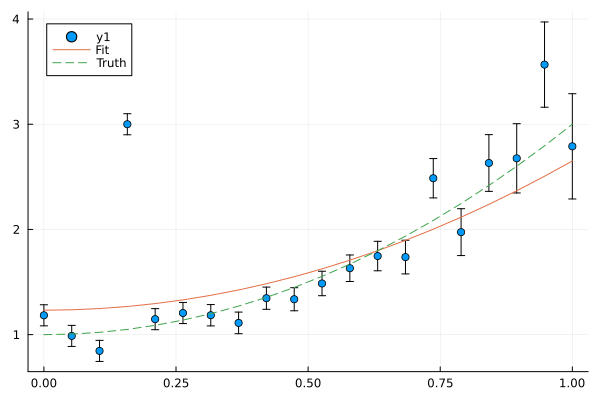

In [21]:
c.y[4] = 3.0   # Generate an outlier
migrad!(m1)
visualize(m1)
plot!(x, yt, label="Truth", linestyle=:dash)

In [22]:
m1

┌──────────────┬──────────────┬───────────┬────────────┬─────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ Up          │
│ 364.426      │              │ 14        │ 3          │ 1.0         │
├──────────────┼──────────────┼───────────┼────────────┼─────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │ Call limit │ Edm         │
│ true         │ true         │ false     │ false      │ 1.50437e-15 │
├──────────────┼──────────────┼───────────┼────────────┼─────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced      │
│ false        │ true         │ true      │ true       │ false       │
└──────────────┴──────────────┴───────────┴────────────┴─────────────┘
┌───┬──────┬─────────┬─────────────┬────────┬────────┬────────┬────────┬────────
│   │ Name │ Value   │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixed ⋯
├───┼──────┼─────────┼─────────────┼────────┼────────┼────────┼────────┼────────
│ 1 │ a    │ 1.23242 │ 0.0372301   │        │  

We can mask the outlier temporary

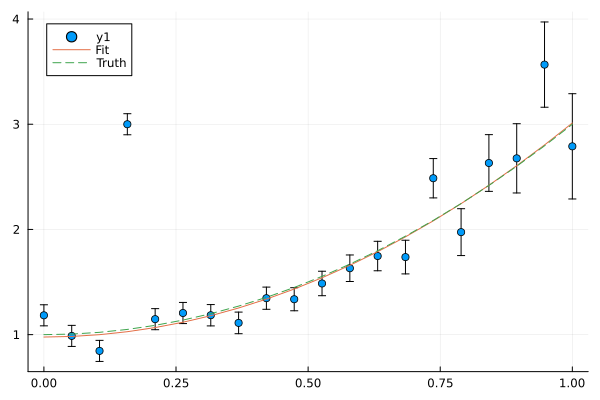

In [23]:
mask = c.y .!= 3.0
c.mask = mask
migrad!(m1)
visualize(m1)
plot!(x, yt, label="Truth", linestyle=:dash)

In [24]:
m1.parameters

┌───┬──────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────
│   │ Name │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixe ⋯
├───┼──────┼──────────┼─────────────┼────────┼────────┼────────┼────────┼───────
│ 1 │ a    │ 0.977444 │ 0.0397061   │        │        │        │        │      ⋯
│ 2 │ b    │ 2.03436  │ 0.154138    │        │        │        │        │      ⋯
└───┴──────┴──────────┴─────────────┴────────┴────────┴────────┴────────┴───────
                                                               2 columns omitted


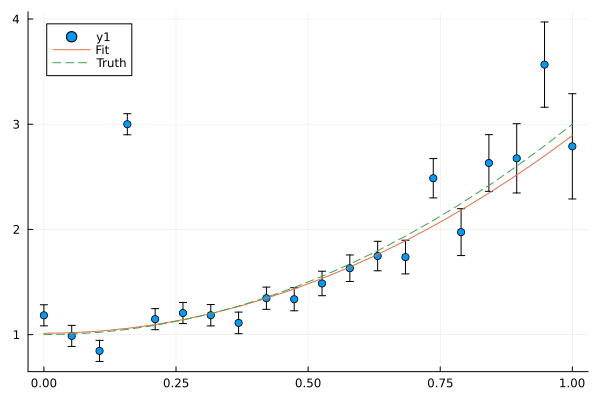

In [25]:
c.mask = nothing
c.loss = :soft_l1
migrad!(m1)
visualize(m1)
plot!(x, yt, label="Truth", linestyle=:dash)

In [26]:
m1.parameters

┌───┬──────┬─────────┬─────────────┬────────┬────────┬────────┬────────┬────────
│   │ Name │ Value   │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixed ⋯
├───┼──────┼─────────┼─────────────┼────────┼────────┼────────┼────────┼────────
│ 1 │ a    │ 1.0129  │ 0.0556629   │        │        │        │        │       ⋯
│ 2 │ b    │ 1.87894 │ 0.222363    │        │        │        │        │       ⋯
└───┴──────┴─────────┴─────────────┴────────┴────────┴────────┴────────┴────────
                                                                1 column omitted
